### This notebook combines the two redshift bins, and also the missed ones.

In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import statmorph

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data


import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [3]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)

'/scratch/gpfs/jiaxuanl/Data/HSC/LSBG'

### The measurement is done by running `sbatch 1k_meas.slurm`, etc. Check `vanilla_measure_all.py` for details.

The measurement catalogs are saved at `./Catalog/NSA/z002_004/lsbg_measure_vaniila_XXXXX.fits`.

Below, we combine these catalogs together.

In [21]:
lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
# print(len(lsbg_cat))

imcomplete_file_ind = np.sort(lsbg_cat[~np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]['viz-id'].data)
print('Number of incomplete files:', len(imcomplete_file_ind))

print('Valid number of objects:', len(lsbg_cat) - len(imcomplete_file_ind))

lsbg_cat = lsbg_cat[np.all(lsbg_cat['image_flag'].data[:, :4], axis=1)]
print(len(lsbg_cat))

Number of incomplete files: 65
Valid number of objects: 10579
10579


In [22]:
np.unique(lsbg_cat['host_name']).shape

(922,)

In [23]:
_, ind = np.unique(lsbg_cat['host_name'].data, return_index=True)
total_area_all = (np.pi * (lsbg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area_all)

Total angular area [deg2]: 89.19904707251214


In [5]:
# suffix = 'nosegmap'
# method = 'vanilla'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_5576_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_2000_2277_{suffix}.fits')
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all_w_missed.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

In [7]:
# np.in1d(imcomplete_file_ind, failed_meas_ind).sum()

In [23]:
# suffix = 'segmap'
# method = 'vanilla'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_5576_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_2000_2277_{suffix}.fits')
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all_w_missed.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

Number of failed fitting and measurement: 443


In [4]:
# suffix = 'nosegmap'
# method = 'vanilla'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_5576_{suffix}.fits'),
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

In [5]:
# suffix = 'segmap'
# method = 'vanilla'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_5576_{suffix}.fits'),
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

In [6]:
# suffix = 'nosegmap'
# method = 'spergel'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_2500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2500_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_3500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3500_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_4500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4500_5576_{suffix}.fits'),
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

In [11]:
# suffix = 'nosegmap'
# method = 'spergel'
# meas_cat_all = vstack([Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z001_002/{method}/_lsbg_meas_{method}_{method}_2000_2791_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2000_2500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_2500_3000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3000_3500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_3500_4000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4000_4500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/_lsbg_meas_{method}_{method}_4500_5576_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_0_500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_500_1000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1000_1500_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_1500_2000_{suffix}.fits'),
#                        Table.read(f'./Catalog/nsa_z002_004/{method}/missed/_lsbg_meas_{method}_{method}_2000_2277_{suffix}.fits')
#                       ])
# assert np.sum(meas_cat_all['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
# meas_cat_all.write(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all_w_missed.fits', overwrite=True)

# failed_meas_ind = np.sort(lsbg_cat[(np.isnan(meas_cat_all['rhalf_circularized']))]['viz-id'].data)

# print('Number of failed fitting and measurement:', len(failed_meas_ind))

Number of failed fitting and measurement: 88


In [10]:
# np.in1d(imcomplete_file_ind, failed_meas_ind).sum()

---
### Analysis: make cuts to rule out junks. START HERE!

In [6]:
import kuaizi
from kuaizi.display import plot_measurement
import pickle
from astropy.cosmology import Planck15
cosmos = Planck15
h = cosmos.h
kuaizi.set_matplotlib(style='nature', usetex=False)

In [7]:
method = 'vanilla'

lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
lsbg_cat.sort('viz-id')

meas_cat = Table.read(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_nosegmap_all_w_missed.fits')
meas_cat.sort('ID')

seg_meas_cat = Table.read(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_segmap_all_w_missed.fits')
seg_meas_cat.sort('ID')

assert np.sum(meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'
assert np.sum(seg_meas_cat['ID'] != lsbg_cat['viz-id']) == 0, 'The two catalogs does not match'

In [7]:
junk = (lsbg_cat['bad_votes'] > lsbg_cat['good_votes'])
candy = (lsbg_cat['good_votes'] > lsbg_cat['bad_votes']) & (lsbg_cat['is_candy'] > lsbg_cat['is_galaxy'])
gal = (~junk) & (~candy)

In [8]:
from sample_cuts import make_cuts_vanilla, make_cuts_spergel

# of Candy: 2318
# of Gal: 4656
# of Junk: 3670


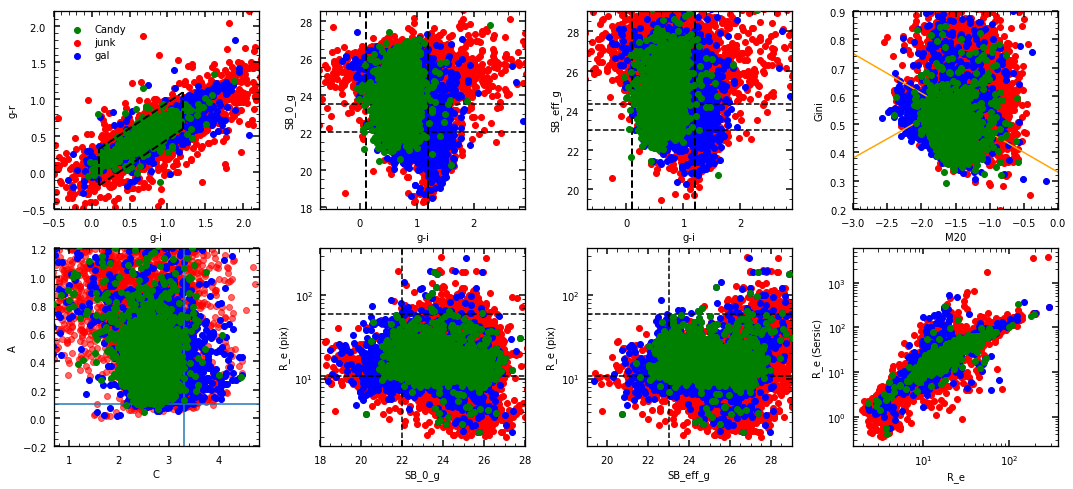

In [9]:
plot_measurement(lsbg_cat, meas_cat)

In [10]:
mask = make_cuts_vanilla(lsbg_cat, meas_cat)

Candy: 1501
Gal: 1089
Junk: 83


# of Candy: 1501
# of Gal: 1089
# of Junk: 83


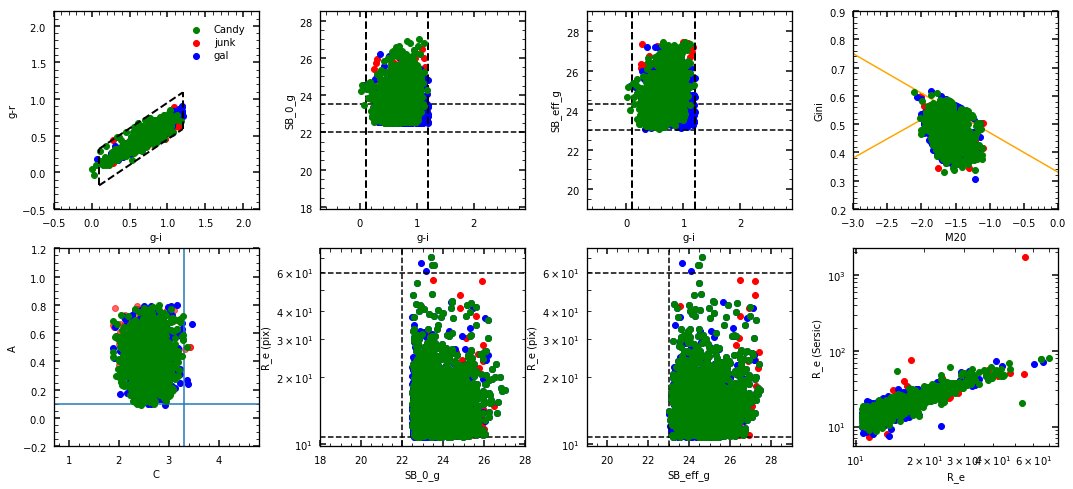

In [11]:
plot_measurement(lsbg_cat[mask], meas_cat[mask])

In [12]:
# Save this mask
np.save(f'./Catalog/nsa_z001_004/lsbg_cuts_mask_{method}_w_missed.npy', mask.data)

---
### Load Spergel catalog, apply mask, plot properties

In [38]:
suffix = 'nosegmap'
method = 'spergel'

lsbg_cat = Table.read('./Catalog/NSA/z001_002/nsa_cutout_cat_z001_002.fits')
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z002_004.fits')])
lsbg_cat = vstack([lsbg_cat, Table.read('./Catalog/NSA/z002_004/nsa_cutout_cat_z001_004_missed.fits')])
lsbg_cat.sort('viz-id')

meas_cat = Table.read(f'./Catalog/nsa_z001_004/{method}/lsbg_meas_{method}_{suffix}_all_w_missed.fits')
meas_cat.sort('ID')
assert np.all(meas_cat['ID'] == lsbg_cat['viz-id']), "Two catalogs do not match!"
mask = np.load('./Catalog/nsa_z001_004/lsbg_cuts_mask_vanilla_w_missed.npy')

cuts_cat = hstack([lsbg_cat[mask], meas_cat[mask]])
print('Number of objs after deblending step:', len(cuts_cat))
# Additional step: remove large R_e in spergel
flag = make_cuts_spergel(cuts_cat)
cuts_cat = cuts_cat[flag]

print('Number of objs after a further R_e cut using spergel:', len(cuts_cat))

Number of objs after deblending step: 2673
Number of objs after a further R_e cut using spergel: 2557


In [14]:
# cuts_cat[~flag][['viz-id', 'ra', 'dec']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/compact_junks.txt', 
#     format='ascii')

In [14]:
### remove overlapping objects
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')

dist_mat = lsbg_coord[None, :].separation(lsbg_coord[:, None]).to(u.deg).value
np.fill_diagonal(dist_mat, 100)

if (dist_mat < (3 * u.arcsec).to(u.deg).value).sum() > 0:
    print('Have overlapping pairs:')
else:
    print('No overlapping objects')

# because dist_mat is symmetric, we set the lower half to a random large number (i.e., 100)
dist_mat[np.triu_indices(len(dist_mat), 0)] = 100
inds = np.vstack(np.where((dist_mat < (3 * u.arcsec).to(u.deg).value)))
print(len(inds.T))

Have overlapping pairs:
47


In [15]:
re_diff = (cuts_cat[inds[0]]['rhalf_spergel'] - cuts_cat[inds[1]]['rhalf_spergel']) * 0.168
# write to vis inspection
from sample_cuts import match_two_arrays
ind1 = cuts_cat[inds[0][np.abs(re_diff) >= 2]]['viz-id'].data
ind2 = cuts_cat[inds[1][np.abs(re_diff) >= 2]]['viz-id'].data
ind = np.vstack([ind1, ind2]).T.ravel()
# cuts_cat[match_two_arrays(cuts_cat['viz-id'].data, ind)][['viz-id', 'ra', 'dec']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_spergel_overlapping.txt', 
#     format='ascii')
# https://tigress-web.princeton.edu/~jiaxuanl/galary/
# after viz inspect, we find remove anyone is fine

In [16]:
to_remove_ind = list(cuts_cat[inds[0]]['viz-id'].data)
cuts_cat = cuts_cat[~np.in1d(cuts_cat['viz-id'], to_remove_ind)]
print('Number of objs after removing overlappers:', len(cuts_cat))

Number of objs after removing overlappers: 2510


# of Candy: 1455
# of Gal: 1001
# of Junk: 54


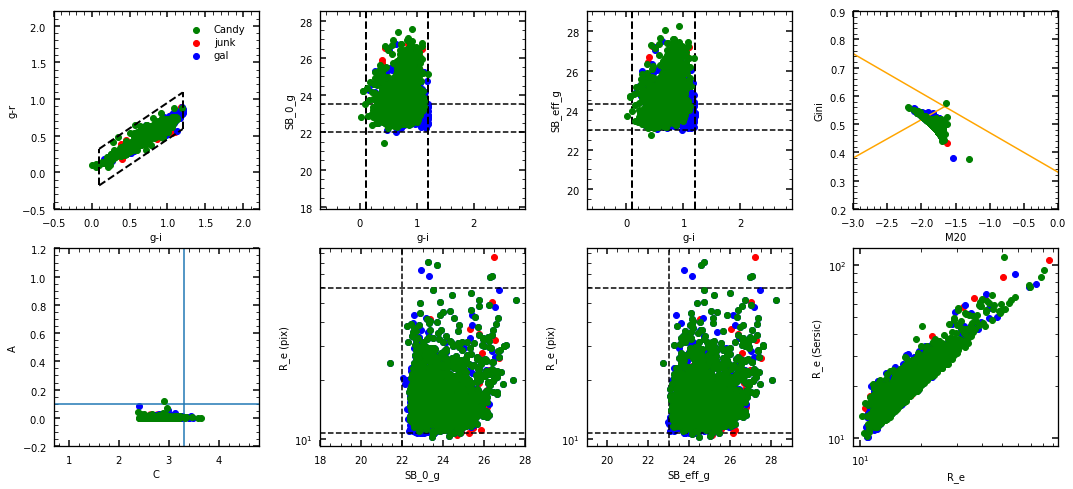

In [17]:
plot_measurement(cuts_cat, cuts_cat)#, gal_zorder=10)

In [18]:
#### Append host color
with open('./Catalog/NSA/nsa_lsbg_match.pkl', 'rb') as f:
    nsa_cat = pickle.load(f)
    
host_gi = []
for name in cuts_cat['host_name'].data:
    host = nsa_cat[nsa_cat['IAUNAME'].data.data == name][0]
    try:
        host_gi.append(-2.5 * np.log10(host['ELPETRO_FLUX'][3] / host['ELPETRO_FLUX'][5]))
    except:
        host_gi.append(np.nan)
        
host_gi = np.array(host_gi)

In [21]:
cuts_cat['host_gi'] = host_gi

In [23]:
cuts_cat.write('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits', overwrite=True)

In [20]:
# cuts_cat[(cuts_cat['C'].data > 3.5) & (cuts_cat['rhalf_spergel'] * 0.168 < 4)][['viz-id', 'ra', 'dec']].write(
#     '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/compact_junks.txt', 
#     format='ascii')

---
### Now select UDG sample

In [21]:
cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')

In [22]:
from sample_cuts import post_process_cat

In [23]:
cuts_cat = post_process_cat(cuts_cat)

Text(0.5, 0, '$d_{ang} / R_{vir, ang}$')

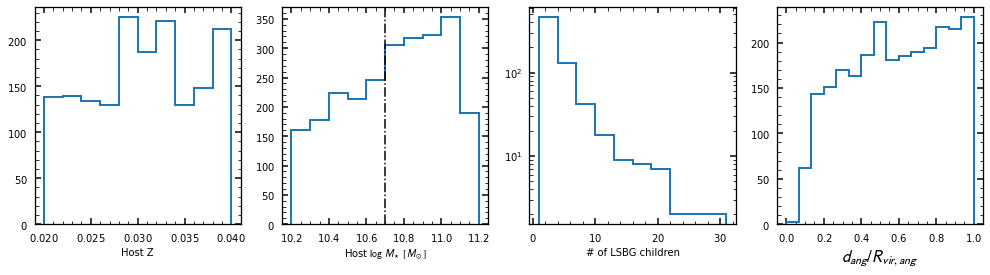

In [24]:
fig, axes = plt.subplots(1, 4, figsize=(17, 4))

plt.sca(axes[0])
plt.hist(cuts_cat['host_z'], range=[0.02, 0.04], 
         bins=10, histtype='step', lw=2);
plt.xlabel('Host Z')

plt.sca(axes[1])
plt.hist(cuts_cat['host_stellar_mass'], range=[10.2, 11.2], 
         bins=10, histtype='step', lw=2);
plt.xlabel(r'Host $\log\, M_\star\ [M_\odot]$')
plt.axvline(10.7, c='k', ls='-.')
plt.subplots_adjust(wspace=0.2)

plt.sca(axes[2])
uniques, counts = np.unique(cuts_cat['host_name'], return_counts=True)
plt.hist(counts, histtype='step', lw=2)
plt.yscale('log')
plt.xlabel('# of LSBG children')

plt.sca(axes[3])
lsbg_coord = SkyCoord(cuts_cat['ra'], cuts_cat['dec'], unit='deg')
host_coord = SkyCoord(cuts_cat['host_RA'], cuts_cat['host_DEC'], unit='deg')
dist = lsbg_coord.separation(host_coord)
plt.hist(dist.to(u.deg).value / cuts_cat['host_r_vir_ang'].data, 
         range=[0, 1.], bins=15, histtype='step', lw=2);
plt.xlabel(r'$d_{ang} / R_{vir, ang}$', fontsize=17)

In [36]:
### UDGs
flag = (cuts_cat['rhalf_phys'] > 1.5) & (cuts_cat['SB_eff_avg'][:, 0] >= 24.4)

print('# of UDGs:', np.sum(flag))
# old: 350

# of UDGs: 433


In [37]:
### ULGs
def mass_size_carlsten(log_m):
    return 1.071 + 0.247 * log_m

# flag = ((np.log10(cuts_cat['rhalf_phys']) + 3 - mass_size_carlsten(cuts_cat['log_m_star'])) > 0.2)
# flag &= (cuts_cat['SB_eff_avg'][:, 0] >= 24.4)
flag = (cuts_cat['rhalf_phys'] > 1.5) & (cuts_cat['SB_eff_avg'][:, 0] >= 24.4)

In [38]:
udg_cat = cuts_cat[flag]

In [39]:
len(udg_cat)

433

In [40]:
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

# of Candy: 347
# of Gal: 73
# of Junk: 13


In [41]:
# old
#junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
# candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
#     udg_cat['is_candy'] > udg_cat['is_galaxy'])
# gal = (~junk) & (~candy)
# print('# of Candy:', np.sum(candy))
# print('# of Gal:', np.sum(gal))
# print('# of Junk:', np.sum(junk))

In [42]:
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_w_missed.txt', 
    format='ascii', overwrite=True)

---
### Visual inspection: mark junks

In [60]:
method = 'spergel'
try:
    Image.open(f'./Figure/nsa_z001_002/{method}/nsa-3159-zoomin-{method}.png')
except:
    pass

try:
    Image.open(f'./Figure/nsa_z002_004/{method}/nsa-3159-zoomin-{method}.png')
except:
    pass

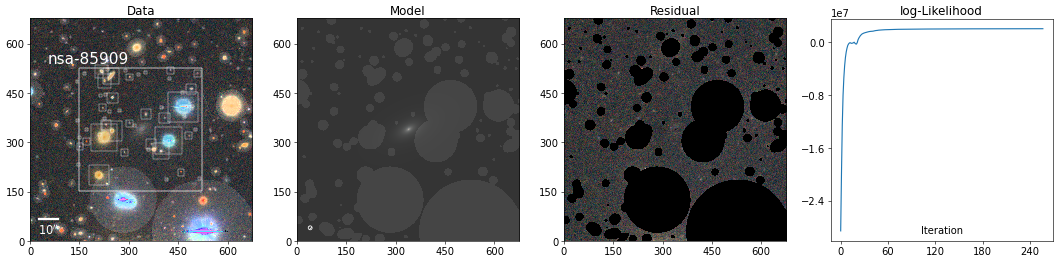

In [77]:
Image.open(f'./Figure/nsa_z002_004/{method}/nsa-85909-zoomin-{method}.png')

In [78]:
votes = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_votes_w_missed.txt',
                   format='ascii')
flag = ~(votes['marked'] == 'true')

In [79]:
udg_cat = udg_cat[flag]

In [80]:
print('Total hosts:', len(np.unique(lsbg_cat['host_name'])))
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UDGs:', len(udg_cat))
print('UDG hosts:', len(np.unique(udg_cat['host_name'])))

print('UDG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Total hosts: 930
Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UDGs: 416
UDG hosts: 274
UDG fraction: 0.6037735849056604

# of Candy: 342
# of Gal: 69
# of Junk: 5


In [81]:
udg_cat.write(f'/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.fits', 
              overwrite=True)
udg_cat[['viz-id', 'ra', 'dec']].write(
    '/tigress/jiaxuanl/public_html/galary/catalogs/nsa_z001_004/udg_z001_004_spergel_after_viz_w_missed.txt', 
    format='ascii')

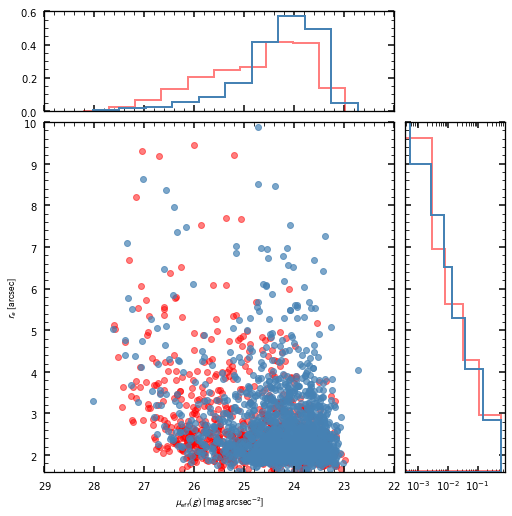

In [83]:
# start with a square Figure
fig = plt.figure(figsize=(8, 8))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


red = ((cuts_cat['mag'][:, 0] - cuts_cat['mag'][:, 2]) > 0.8)

ax.scatter(cuts_cat[red]['SB_eff_avg'][:, 0], 
           cuts_cat[red]['rhalf_spergel'], 
           color='r', alpha=0.5)
ax.scatter(cuts_cat[~red]['SB_eff_avg'][:, 0], 
            cuts_cat[~red]['rhalf_spergel'],
            color='steelblue', alpha=0.7)
ax.set_xlim(29, 22)
ax.set_ylim(1.6, 10)
ax.set_xlabel(r'$\mu_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm arcsec]$')

ax_histx.hist(cuts_cat[red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histx.hist(cuts_cat[~red]['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue')
ax_histy.hist(cuts_cat[red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(cuts_cat[~red]['rhalf_spergel'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_xscale('log')